In [2]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Exercise 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

Consider the following matrix
$X \in \mathbb{R}^{400×400}$ defined as:

$$
X_{ij}(n) =
\begin{cases}
110, & \text{if } 50 \leq i \leq 150 \text{ and } 30 \leq j \leq 130 \\
150, & \text{if } 50 \leq i \leq 150 \text{ and } 230 \leq j \leq 330 \\
180, & \text{if } 250 \leq i \leq 350 \text{ and } 70 \leq j \leq 170 \\
220, & \text{if } 250 \leq i \leq 350 \text{ and } 270 \leq j \leq 370 \\
0,   & \text{otherwise}
\end{cases}
$$


Where $i,j=1,...,400$


In [ ]:
# Define the dimensions of the matrix
rows, cols = 400, 400

# Initialize the matrix with zeros
X = np.zeros((rows, cols))

# Define the regions with their corresponding values
regions = [
    ((50, 150), (30, 130), 110),
    ((50, 150), (230, 330), 150),
    ((250, 350), (70, 170), 180),
    ((250, 350), (270, 370), 220),
]

# Fill the matrix with the defined values for the specified regions
for (start_i, end_i), (start_j, end_j), value in regions:
    X[start_i : end_i + 1, start_j : end_j + 1] = value

# Print the resulting matrix
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Add a synthetic noise by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 0.2$.


In [5]:
# Add synthetic noise sampled from a Gaussian distribution
sigma = 0.2
noise = np.random.normal(loc=0, scale=sigma, size=(rows, cols))
X_noise = X + noise

In [ ]:
def plot_s_values(X):
    _, s, _ = np.linalg.svd(X, full_matrices=False)

    _, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

    axes.semilogy(s, "o-")
    axes.set_title("Singluar values")

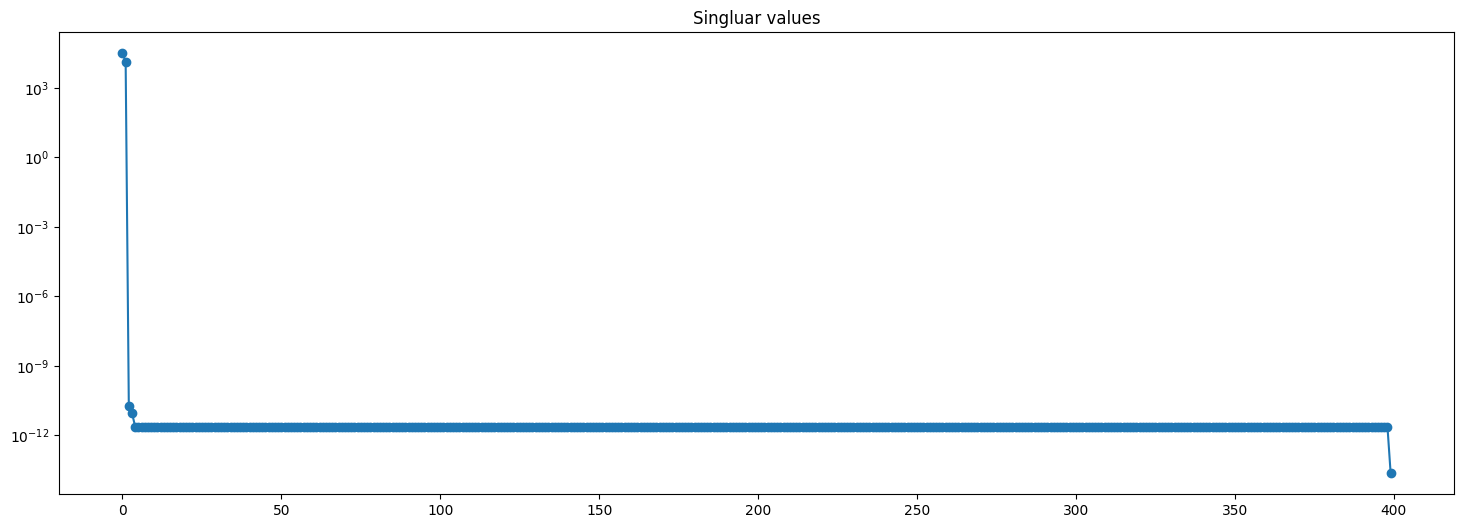

In [9]:
plot_s_values(X)

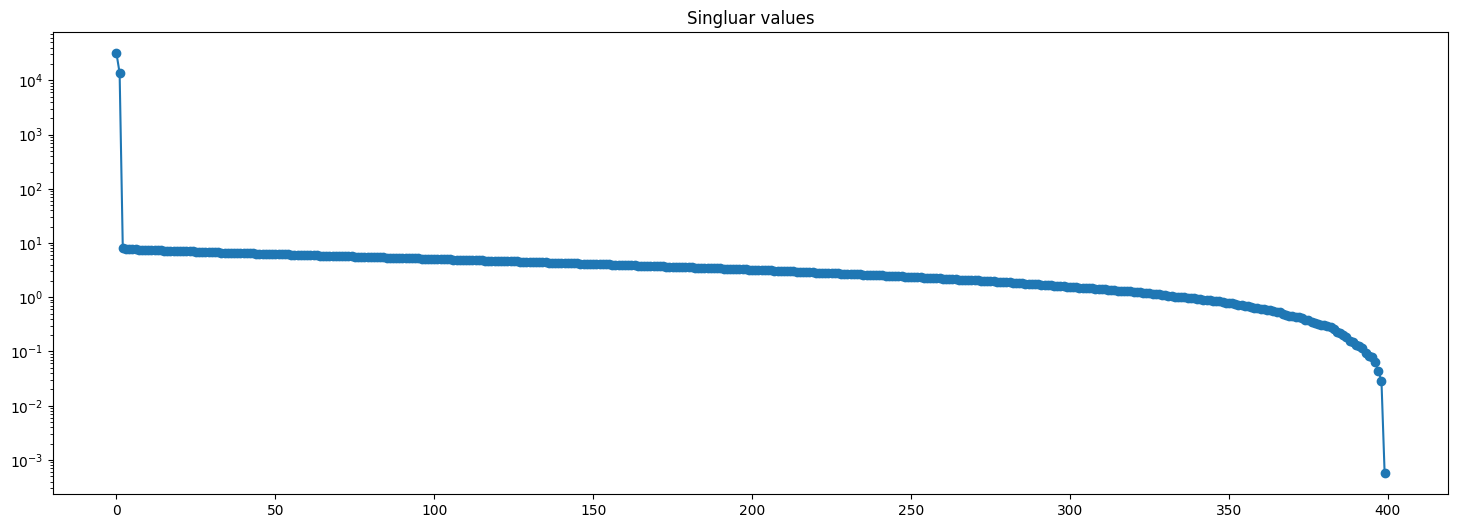

In [8]:
plot_s_values(X_noise)

Implement the singular value truncation (SVT) algorithm and apply it to reconstruct the original matrix
X from $X_{noise}$. Set a maximum number of iteration equal to 50, a tolerance on the increment equal to
$10^{−6}$ and try to optimize the threshold on the singular values by trial and error. Compute the relative reconstruction error between $X$ and the approximation $\hat{X}$, defined as:

$$
\epsilon_R = {{||X - \hat{X}||_F}\over{||X||_F}},
$$

the rank $\hat{r}$ of $\hat{X}$ and visualize the true image and its approximation.


In [ ]:
def svt(X_noise, r, max_iter=50, tol=1e-6, tau=0.1):
    U, S, V = np.linalg.svd(X_noise, full_matrices=False)
    S_thresholded = np.maximum(S - tau, 0)
    X_hat = U @ np.diag(S_thresholded) @ V
    X_prev = X_hat.copy()
    for i in range(max_iter):
        U, S, V = np.linalg.svd(X_prev, full_matrices=False)
        S_thresholded = np.maximum(S - tau, 0)
        X_hat = U @ np.diag(S_thresholded) @ V
        if np.linalg.norm(X_hat - X_prev, "fro") / np.linalg.norm(X_hat, "fro") < tol:
            break
        X_prev = X_hat.copy()
    return X_hat, np.sum(S_thresholded > 0)

Relative reconstruction error: 0.0005762850348398545
Rank of the approximation: 2


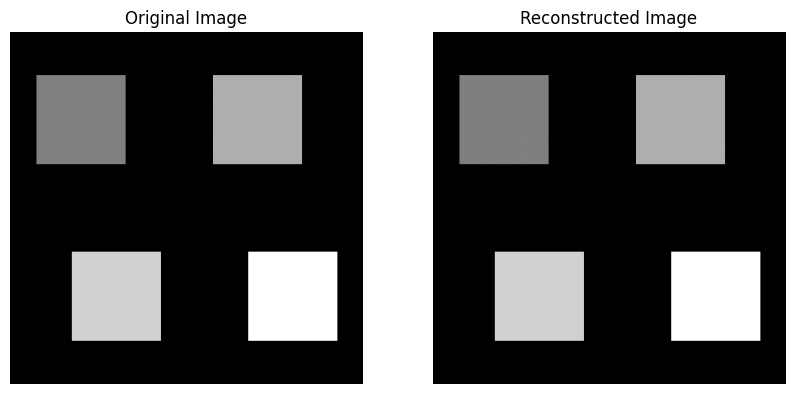

In [ ]:
max_iter = 50
tol = 1e-6
tau = 0.25

X_hat, rank_hat = svt(X_noise, r=None, max_iter=max_iter, tol=tol, tau=tau)

epsilon_r = np.linalg.norm(X - X_hat, "fro") / np.linalg.norm(X, "fro")

print("Relative reconstruction error:", epsilon_r)
print("Rank of the approximation:", rank_hat)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(X_hat, cmap="gray")
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()

Find, by means of exact SVD, the value of k providing a relative reconstruction error equal to the one
obtained in the previous point. Comment the results.


In [ ]:
U, S, V = np.linalg.svd(X_noise, full_matrices=False)

target_epsilon_r = epsilon_r

k = 1
epsilon_r_diff = float("inf")
while epsilon_r_diff > 1e-6 and k < min(rows, cols):
    X_hat_k = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
    epsilon_r_k = np.linalg.norm(X - X_hat_k, "fro") / np.linalg.norm(X, "fro")
    epsilon_r_diff = abs(epsilon_r_k - target_epsilon_r)
    k += 1

k -= 1

print("Value of k providing similar relative reconstruction error:", k)

Value of k providing similar relative reconstruction error: 399


Repeat the previous point by means of randomized SVD. Comment the results


In [ ]:
def randomized_svd(X, k):
    _, n = X.shape

    # Generate a Gaussian random matrix
    omega = np.random.randn(n, k)

    # Form the sample matrix
    Y = X @ omega

    # Orthonormalize the sample matrix
    Q, _ = np.linalg.qr(Y, mode="reduced")

    # Compute the approximate SVD of the projected matrix
    B = Q.T @ X
    U_tilde, S, V = np.linalg.svd(B, full_matrices=False)

    # Compute the approximate left singular vectors
    U = Q @ U_tilde

    return U, S, V[:k]

In [ ]:
U, S, V = randomized_svd(X_noise, 1)

target_epsilon_r = epsilon_r

k = 1
epsilon_r_diff = float("inf")
while epsilon_r_diff > 1e-6 and k < min(rows, cols):
    U, S, V = randomized_svd(X_noise, 1)
    X_hat_k = U @ np.diag(S) @ V
    epsilon_r_k = np.linalg.norm(X - X_hat_k, "fro") / np.linalg.norm(X, "fro")
    epsilon_r_diff = abs(epsilon_r_k - target_epsilon_r)
    k += 1

k -= 1

print(
    "Value of k providing similar relative reconstruction error using randomized SVD:",
    k,
)

Value of k providing similar relative reconstruction error using randomized SVD: 399


# Exercise 2


Compute the relative reconstruction error between the original matrix X and the approximation $\hat{X}$ obtained using the randomized SVD and by varying k. The expression of the relative reconstruction error is given by
$$
\epsilon_R = {{|| X - \hat{X}||_F}\over{||X||_F}}.
$$
Visualize the trend of the error with respect to the rank k and comment the results.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

Consider the function

$$J(x, y) = 2x^2 - 1.05x^4 + \frac{x^6}{6} + xy + y^2  \tag{1}$$

where $ x = (x, y)^T $.


In [19]:
def J(x, y):
    return 2 * x ** 2 - 1.05 * x ** 4 + x ** 6 / 6 + x * y + y ** 2

Compute and characterize the stationary points of (1). Moreover compute the corresponding function values.

In [20]:
# Define the gradient of J
def gradient_J(x, y):
    return np.array([4 * x - 4.2 * x ** 3 + x ** 5 + y, x + 2 * y])

# Define the Hessian of J
def hessian_J(x, y):
    return np.array([[4 - 12.6 * x ** 2 + 5 * x ** 4, 1], [1, 2]])

Given the system of equations:

$$
\begin{cases}
\frac{\partial J}{\partial x} = 4x - 4.2x^3 + x^5 + y = 0 \\
\frac{\partial J}{\partial y} = x + 2y = 0
\end{cases}
$$

We can solve the second equation for $ x $ and substitute it into the first equation to solve for $ y $. Let's do it:

From the second equation:

$$
x = -2y
$$

Substituting $ x $ into the first equation:

$$
4(-2y) - 4.2(-2y)^3 + (-2y)^5 + y = 0 \\
-8y + 33.6y^3 - 32y^5 + y = 0 \\
-32y^5 + 33.6y^3 - 7y = 0
$$

In [21]:
# Define the quintic equation
def quintic_equation(y):
    return -32*y**5 + 33.6*y**3 - 7*y

# Solve the quintic equation numerically
y_roots = np.roots([-32, 0, 33.6, 0, -7, 0])

# Find corresponding values of x
x_roots = [-2*y for y in y_roots]

# Compute the function values at the stationary points
function_values = [J(x, y) for x, y in zip(x_roots, y_roots)]

# Print the stationary points and their corresponding function values
for i, (x, y) in enumerate(zip(x_roots, y_roots)):
    print(f"Stationary Point {i+1}: (x, y) = ({x}, {y}), J(x, y) = {function_values[i]}")

Stationary Point 1: (x, y) = (1.7475523458302908, -0.8737761729151454), J(x, y) = 0.29863844223686076
Stationary Point 2: (x, y) = (1.07054229182366, -0.53527114591183), J(x, y) = 0.87736155776314
Stationary Point 3: (x, y) = (-1.7475523458302888, 0.8737761729151444), J(x, y) = 0.29863844223686076
Stationary Point 4: (x, y) = (-1.0705422918236602, 0.5352711459118301), J(x, y) = 0.87736155776314
Stationary Point 5: (x, y) = (-0.0, 0.0), J(x, y) = 0.0


Plot the function $J(x)$ as a contourplot and as a surface (Hint: use the commands contour and surf
from Matplotlib).

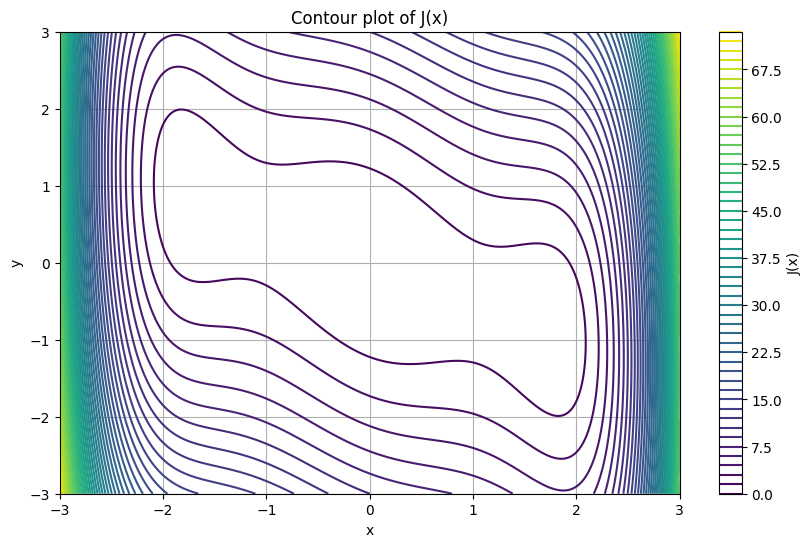

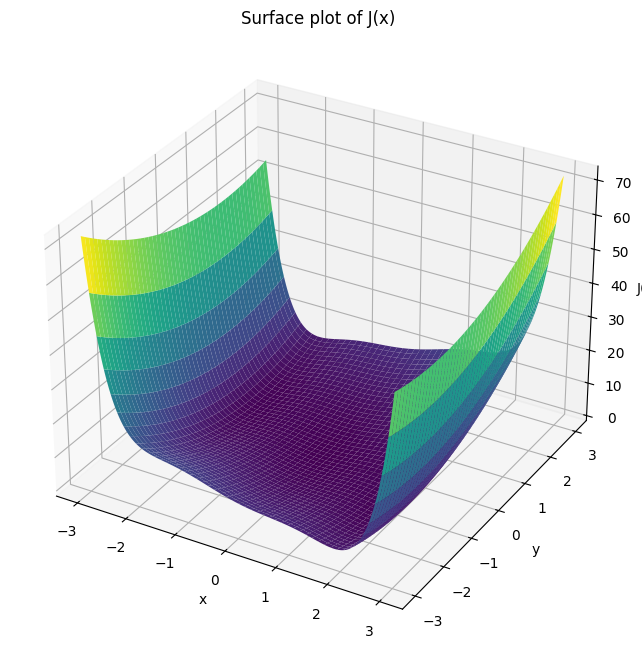

In [22]:
# Generate x and y values
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = J(X, Y)

# Plot as contour plot
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='J(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of J(x)')
plt.grid(True)
plt.show()

# Plot as surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('J(x)')
ax.set_title('Surface plot of J(x)')

plt.show()

Implement the Newton method for computing the minimum of a function. The input parameters should
be: the function J, the gradient of J, the Hessian of J, the initial guess, the tolerance and the maximum
number of iterations. The stopping criterium should be $ |J(x^{(k+1)}) − J(x
^{(k)})|$. The output should be the
history of the iterates $x^{(k)}$ and the history of the corresponding functional values $J(x^{(k)})$.


In [23]:
def newton_method(J, gradient_J, hessian_J, initial_guess, tolerance=1e-6, max_iterations=100):
    x_history = [initial_guess]
    J_history = [J(*initial_guess)]

    x_current = np.array(initial_guess)

    for i in range(max_iterations):
        gradient = gradient_J(*x_current)
        hessian = hessian_J(*x_current)

        # Check for convergence
        if np.linalg.norm(gradient) < tolerance:
            break

        # Compute the search direction using Newton's method
        search_direction = np.linalg.solve(hessian, -gradient)

        # Update the current point
        x_current += search_direction

        # Update history
        x_history.append(x_current)
        J_history.append(J(*x_current))

        # Check for convergence based on functional values
        if np.abs(J_history[-1] - J_history[-2]) < tolerance:
            break

    return x_history, J_history

Apply the code developed at the previous point to (1). Use a tolerance $\epsilon = 10^{-6}$ and set the maximum
number of iterations equal to 100. Consider the following initial guesses 
$$
x^0 = (2.5, −2.5), \\
x^0 = (0.8, −2.5), \\
x^0 = (−0.4, −2.5).
$$
For each initial point plot the convergence history on the contourplot and the
history of the function values. Comment the results.

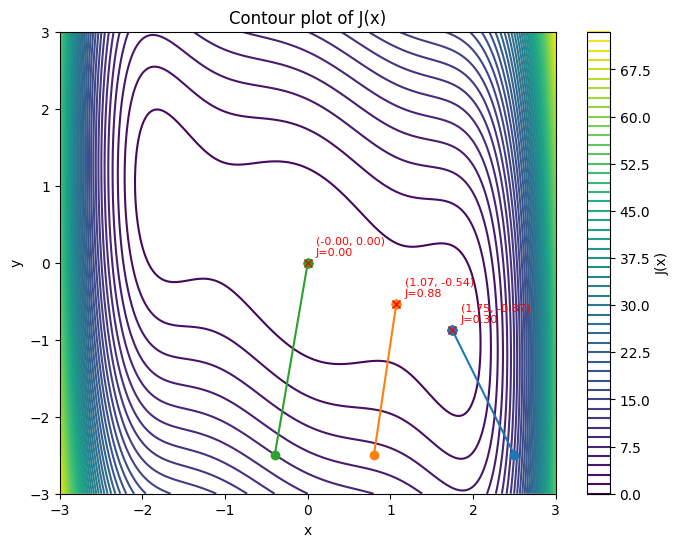

In [34]:
# Initial guesses
initial_guesses = [(2.5, -2.5), (0.8, -2.5), (-0.4, -2.5)]

# Tolerance and maximum number of iterations
tolerance = 1e-6
max_iterations = 100

# Plot the contour plot of the function
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = J(X, Y)

plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='J(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of J(x)')

for initial_guess in initial_guesses:
    # Run Newton's method
    x_history, J_history = newton_method(J, gradient_J, hessian_J, initial_guess, tolerance, max_iterations)

    # Extract trajectory
    x_values = [x[0] for x in x_history]
    y_values = [x[1] for x in x_history]
    plt.plot(x_values, y_values, marker='o', label=f'Initial Guess: {initial_guess}')
    
    # Get final point
    final_x, final_y = x_history[-1]
    final_val = J(final_x, final_y)
    
    # Annotate convergence point
    plt.plot(final_x, final_y, 'rx')  # red X marker
    plt.text(final_x + 0.1, final_y + 0.1,
             f'({final_x:.2f}, {final_y:.2f})\nJ={final_val:.2f}',
             fontsize=8, color='red')

The convergence points highly depends on the initialization: in fact by starting from different points we reach different saddle points that may correspond to local minimum.